## Record Linkage 
    
**Retailer A and Retailer B**, two large-scale department store chains, have shared their product descriptions datasets for the purpose of cross-promotion, product indexing and targeted marketing.

The goal is to identify which products in Retailer B's dataset are also products of Retailer A. This will allow the marketing department to create more personalized product offering campaigns and product indexes.

The datasets can be found in CSV format:

    - retailerA.csv
    - retailerB.csv 

In [1]:
import time
start_time = time.time()

# Loading data
import pandas as pd

# Tokenization and data prep
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('punkt') # punctuation words
nltk.download('stopwords') # stop words

# Entity matching (similarity matrix)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Entity Clustering

import hdbscan # clustering algorithm
from sklearn.decomposition import PCA # dimension reduction
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting toolkit
import numpy as np # for testing
import matplotlib.pyplot as plt

end_time = time.time()
import_time = end_time - start_time
print(f"Libraries Import Time: {import_time} seconds")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zemariatrindade/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zemariatrindade/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Libraries Import Time: 23.425863027572632 seconds


### Exploratory Data Analysis and Preparation

In this section, I'm going to get an overview of the datasets we are working with, and evaluate what's the best strategy to cluster products across retailers.

In [2]:
def loadData(csv1_name, csv2_name):
        
        retailerA = pd.read_csv("retailerA.csv")
        retailerB = pd.read_csv("retailerB.csv")

        return retailerA, retailerB

In [3]:
start_time = time.time()

retailerA, retailerB = loadData("retailerA.csv","retailerB.csv")

end_time = time.time()
print(f"Data Loading Time: {end_time - start_time} seconds")

Data Loading Time: 0.15803098678588867 seconds


In [4]:
# Checking the number of products for retailerA
retailerA.info() # There are 1081 entries, but the price column only has 418 entries.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   unique_id    1081 non-null   int64 
 1   title        1081 non-null   object
 2   description  1081 non-null   object
 3   price        418 non-null    object
dtypes: int64(1), object(3)
memory usage: 33.9+ KB


In [5]:
# Checking the number of products for retailerB
retailerB.info() # There are 1092 entries for title attribute, but only 646 and 590 for description and price attributes, respectively.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   unique_id    1092 non-null   int64 
 1   title        1092 non-null   object
 2   description  646 non-null    object
 3   price        590 non-null    object
dtypes: int64(1), object(3)
memory usage: 34.3+ KB


- At this point, we can say that we will do the entity resolution and clustering to the title atributte given that is the one that can use the most records in each retailer, unless there is a significant amount of duplicates and NaN values.

In [6]:
# Let's check if there are duplicates in the title attribute for retailerA
retailerA[retailerA["title"].duplicated()]

,unique_id,title,description,price


In [7]:
# Let's check if there are duplicates in the title attribute for retailerB
retailerB[retailerB["title"].duplicated()] # we have some cases.

,unique_id,title,description,price
412,403,Peerless SmartMount 700 Series Articulating Wa...,Peerless SA750PU - Articulating Wall Arm for 3...,NaN
456,445,The LG Electric SteamDryer,NaN,NaN
768,755,LG 25.0 Cu.Ft. Total Capacity,NaN,NaN
769,756,LG 25.0 Cu.Ft. Total Capacity,NaN,NaN
770,757,LG 25.0 Cu.Ft. Total Capacity,NaN,NaN
783,770,LG 5.6 cu.ft. Freestanding Electric Range,NaN,NaN
784,771,LG 5.6 cu.ft. Freestanding Electric Range,NaN,NaN
785,772,LG 5.6 cu.ft. Freestanding Electric Range,NaN,NaN
786,773,LG 5.6 cu.ft. Freestanding Electric Range,NaN,NaN
788,775,LG 5.0 cu.ft. Freestanding Gas Range,NaN,NaN


We could drop duplicates here, but it seems that there is no repition of unique IDs and therefore would be dangerours to delete any records.

In [8]:
# Let's check for NaN values for retailerA
retailerA[retailerA["title"].isna()] # there seems to be no NaN values in the title attribute

,unique_id,title,description,price


In [9]:
# Let's check for NaN values for retailerB
retailerB[retailerB["title"].isna()] # there seems to be no NaN values in the title attribute

,unique_id,title,description,price


In [10]:
print("Number of title records for retailer A:",retailerA["title"].value_counts().sum())
print("Number of title records for retailer B:",retailerB["title"].value_counts().sum())

Number of title records for retailer A: 1081
Number of title records for retailer B: 1092


**Conclusion**: As a result of this analysis, we will apply the entity resolution to the title attribute of both retailers.

## Step 1: Data cleaning

Performing data cleaning with the help of regex expressions, removal of stopwords and the tokenization of the documents/sentences or paragraphs.

1. We will use a combined list with all the titles of products from both retailers
2. In this exercise, I'm going to use the package NLTK tokenizer.

**ChatGPT 3.5**

- If our goal is to tokenize titles and you are looking for a lightweight solution, the NLTK (Natural Language Toolkit) library is a good option. NLTK is known for its simplicity and ease of use, and it provides a variety of tokenizers.

In [11]:
def tokenizeData(df1,df2):
   
    # Combining titles of retailer A and B in a single list
    titles = df1["title"].tolist() + df2["title"].tolist()

    # Getting the total number of records of retailerA so we can later split the list in two
    nr_of_docs_A = len(df1["title"])
    
    # Get English stop words and punctuation
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    
    # Tokenizing the list of sentences ("titles")
    tokenized_titles = [
        [word.lower() for word in word_tokenize(title) 
         if word.lower() not in stop_words and word.lower() not in punctuation] for title in titles]

    return tokenized_titles, nr_of_docs_A

In [12]:
start_time = time.time()
tokenized_titles, nr_of_docs_A = tokenizeData(retailerA, retailerB)
end_time = time.time()
print(f"Cleaning Time: {end_time - start_time} seconds")

Cleaning Time: 0.2667257785797119 seconds


## Step 2: Entity Matching

For every product record in the retailer A, we need to compute its similarity to every record in retailer B.

In [13]:
def computeSimilarity(tokenized_titles, nr_of_docs_A):
    
    # Convert tokenized titles back to strings for TF-IDF
    document_texts = [' '.join(tokens) for tokens in tokenized_titles]

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(document_texts)

    # At this point there is a long matrix with records being the products and features being tokens 
    
    # Cosine Similarity Matrix between the 2 sets of products combined
    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

    return cosine_sim_matrix, nr_of_docs_A

In [14]:
start_time = time.time()
cosine_sim_matrix, nr_of_docs_A = computeSimilarity(tokenized_titles, nr_of_docs_A)
end_time = time.time()
print(f"Matching Time: {end_time - start_time} seconds")

Matching Time: 0.10280966758728027 seconds


In [15]:
# Visualize Cosine similarity in a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index = retailerA["title"].tolist()+retailerB["title"].tolist(), columns = retailerA["title"].tolist()+retailerB["title"].tolist())
cosine_sim_df.head()

,Linksys EtherFast 8-Port 10/100 Switch - EZXS88W,Linksys EtherFast10/100 5-Port Auto-Sensing Switch - EZXS55W,Netgear ProSafe 5 Port 10/100 Desktop Switch - FS105,Belkin F3H982-10 Pro Series High Integrity 10 Feet Monitor Cable - F3H98210,Netgear Prosafe 16 Port 10/100 Rackmount Switch - Black Finish - JFS516NA,LaCie USB 2.0 Floppy Disk Drive - 706018,Canon KP-36IP Color Ink & Paper Set - 7737A001,Kensington Orbit Optical Trackball Mouse - 64327,Linksys EtherFast4116 16-Port 10/100 Ethernet Switch - EF4116,Linksys EtherFast 4124 24-Port Ethernet Switch - EF4124,...,Garmin 010-00577-30 Nvi(r) 885t Travel Assistant,Samsung LN32A450 32' 720p LCD HDTV,Maytag MDB7851AWB Full Console Dishwasher (Black),Whirlpool DU1100XTPS 24' Undercounter Dishwasher (Stainless Steel),Canon XH A1S - 3238B001,Sony VAIO FW378J/B Notebook - VGNFW378J/B,Sennheiser CX380 Sennheiser CX 380 Sport II Grey/Orange,IWORK 09 RETAIL-INT DVD - MB942Z/A,IWORK 09 FAMILY PACK-INT DVD - MB943Z/A,CASE MATE CARBON FIBER IPHONE 3G CASE BLACK - IPH3GC-BCF
Linksys EtherFast 8-Port 10/100 Switch - EZXS88W,1.000000,0.410289,0.459142,0.137132,0.390311,0.0,0.0,0.0,0.495500,0.468783,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Linksys EtherFast10/100 5-Port Auto-Sensing Switch - EZXS55W,0.410289,1.000000,0.309092,0.000000,0.262755,0.0,0.0,0.0,0.347357,0.255868,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Netgear ProSafe 5 Port 10/100 Desktop Switch - FS105,0.459142,0.309092,1.000000,0.129625,0.576691,0.0,0.0,0.0,0.388717,0.205163,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Belkin F3H982-10 Pro Series High Integrity 10 Feet Monitor Cable - F3H98210,0.137132,0.000000,0.129625,1.000000,0.110192,0.0,0.0,0.0,0.116098,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Netgear Prosafe 16 Port 10/100 Rackmount Switch - Black Finish - JFS516NA,0.390311,0.262755,0.576691,0.110192,1.000000,0.0,0.0,0.0,0.454882,0.174407,...,0.0,0.0,0.020831,0.0,0.0,0.0,0.0,0.0,0.0,0.015224


## Step 3: Entity clustering

Once entities have been resolved as matches. we need to  merge them in order to produce a single representative record. This involves grouping the entities based on the similarity scores. Entities or records in the same cluster are considered to be the same.

**Choosing the algorithim**

In order to perform Entity Clustering, we are going to use the **HDBSCAN** (Hierarchical Density-Based Spatial Clustering of Applications with Noise).

Given that we want to explore clusters in high-dimensional space, we preferably need a algorithm that can identify clusters of arbitrary shapes, while automatically determining the number of clusters.

**Chat GPT 3.5:** HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is typically designed to work with a distance or dissimilarity matrix rather than a similarity matrix. This means that when using HDBSCAN, you would often need to transform your cosine similarity matrix into a dissimilarity matrix.

HDBSCAN works with the concept of mutual reachability distance, which is a form of dissimilarity. The common practice is to subtract the similarity values from 1 to obtain dissimilarity values. Therefore, **transforming your cosine similarity matrix to a dissimilarity matrix (e.g., 1 - cosine_similarity_matrix) is a common step when applying HDBSCAN.**

In [16]:
def generateClusters(cosine_sim_matrix, nr_of_docs_A):
    
    # Transform to dissimilarity matrix
    dissimilarity_matrix = 1 - cosine_sim_matrix

    # Use HDBSCAN with transformed dissimilarity matrix
    clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='precomputed',gen_min_span_tree=True ).fit(dissimilarity_matrix)
    clusters = clusterer.labels_
    
    # Use PCA for dimensionality reduction
    pca = PCA(n_components=3)
    reduced_data_to_plot = pca.fit_transform(cosine_sim_matrix)
    
    # Assign the cluster labels to retailerA df as "Cluster ID"
    retailerA["Cluster ID"] = clusters[:nr_of_docs_A]
    
    # Assign the cluster labels to retailerB df as "Cluster ID"
    retailerB["Cluster ID"] = clusters[nr_of_docs_A:]
    
    return clusters, reduced_data_to_plot, pca

In [17]:
start_time = time.time()
clusters, reduced_data_to_plot, pca = generateClusters(cosine_sim_matrix, nr_of_docs_A)
end_time = time.time()
print(f"Clustering Time: {end_time - start_time} seconds")

Clustering Time: 1.3084280490875244 seconds


#### Visualization

To visualize the entity clustering, we will use Dimensionality Reduction Techniques like PCA (Principal Component Analysis) to reduce the number of features to 3 dimensions.

- **2-D Representation**

In [18]:
def visualize2D(clusters,reduced_data_to_plot):
    
    for cluster in range(max(set(clusters))):
        cluster_points = reduced_data_to_plot[clusters == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster + 1}')

    plt.title('HDBSCAN Clustering Results')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

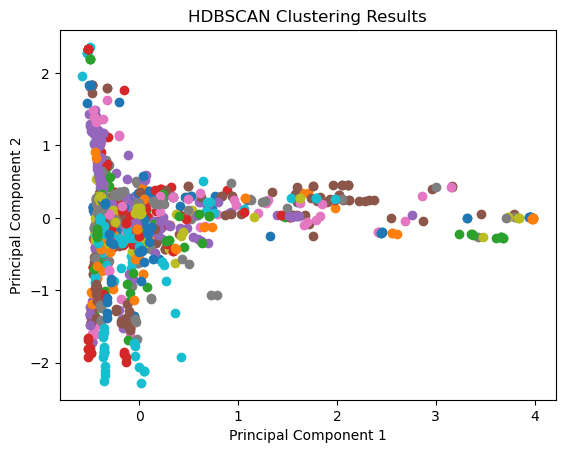

2D Visualization Time: 3.624194860458374 seconds


In [19]:
start_time = time.time()
visualize2D(clusters,reduced_data_to_plot)
end_time = time.time()
print(f"2D Visualization Time: {end_time - start_time} seconds")

- **3-D Representation**

In [20]:
def visualize3D(clusters,reduced_data_to_plot):   
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for cluster in range(max(set(clusters))):
        cluster_points = reduced_data_to_plot[clusters == cluster]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster + 1}')

    ax.set_title('HDBSCAN Clustering Results (3D)')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    plt.show()

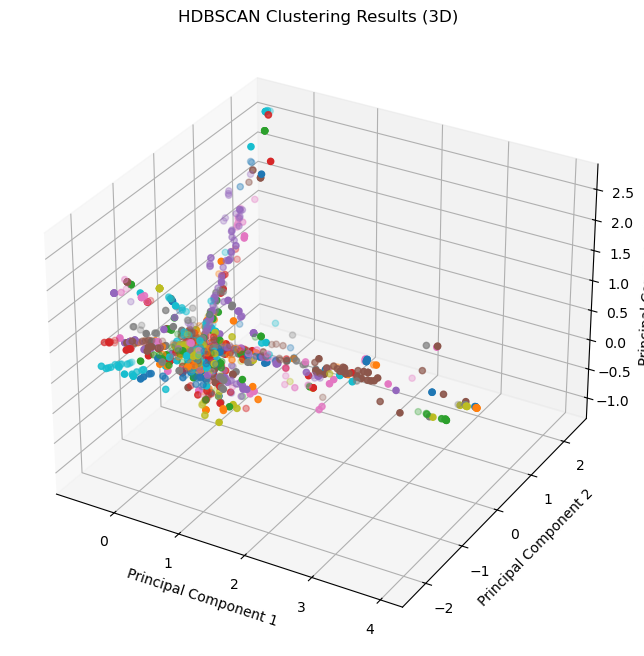

3D Visualization Time: 2.2630772590637207 seconds


In [21]:
start_time = time.time()
visualize3D(clusters,reduced_data_to_plot)
end_time = time.time()
print(f"3D Visualization Time: {end_time - start_time} seconds")

- **Tabular Visualization**

Retailer A df sorted by Cluster ID (from 1 to 4 included)

In [28]:
retailerA[(retailerA["Cluster ID"]>0) & (retailerA["Cluster ID"]<5)].sort_values("Cluster ID")

,unique_id,title,description,price,Cluster ID
274,273,Panasonic Silver Rice Cooker/Warmer - SRTMB10,Panasonic Silver Rice Cooker/Warmer - SRTMB10/...,NaN,1
311,310,Panasonic SR-NA18 White Deluxe Fuzzy Logic Ric...,Panasonic SR-NA18 White Deluxe Fuzzy Logic Ric...,NaN,1
112,112,Kensington MicroSaver Keyed Notebook Lock - 64...,Kensington MicroSaver Keyed Notebook Lock - 64...,NaN,2
355,354,Kensington Combosaver Ultra Combination Notebo...,Kensington Combosaver Ultra Combination Notebo...,$39.00,2
266,265,Oregon Scientific AT18 Wearable Waterproof Act...,Oregon Scientific AT18 Wearable Waterproof Act...,NaN,3
1014,1010,Twenty20 VholdR Mount Adhesive - 2200MA,Twenty20 VholdR Mount Adhesive - 2200MA/ Remov...,$6.00,3
1028,1024,Twenty20 VholdR Wearable Camcorder Bundle - 1102,Twenty20 VholdR Wearable Camcorder Bundle - 11...,NaN,3
138,138,Fellowes Confetti Cut Shredder - W11C,Fellowes Confetti Cut Shredder - W11C/ Shreds ...,$79.00,4
258,257,Fellowes MicroShred Shredder - MS450CS,Fellowes MS-450CS MicroShred Shredder - MS450C...,$189.00,4
259,258,Fellowes Personal Powershred Shredder - SB97CS,Fellowes Personal Powershred Shredder - SB97CS...,NaN,4


In [22]:
retailerB[(retailerB["Cluster ID"]>0) & (retailerB["Cluster ID"]<5)].sort_values("Cluster ID")

,unique_id,title,description,price,Cluster ID
277,273,Panasonic Srtmb10/Rice Cooker/5.5cup/Fuzzy - S...,NaN,NaN,1
315,310,Panasonic SR-NA18 10-Cup Rice Cooker/Warmer wi...,NaN,NaN,1
114,112,Kensington MicroSaver Notebook Lock - 64068F,Steel - 6ft,NaN,2
359,354,Kensington ComboSaver Ultra Notebook Lock - K6...,Combosaver Ultra Combination Notebook Lock,NaN,2
1024,1010,VholdR 2200 Mount Adhesive (Black),NaN,NaN,3
1038,1024,VholdR Wearable Camcorder (Black) - 1102,NaN,NaN,3
1042,1028,Battery and Bag Bundle for Panasonic Camcorder...,NaN,NaN,3
142,138,Fellowes Powershred Personal W11C Shredder - 3...,Cross Cut - 11 Per Pass - 5.5 Gallon Wastebasket,NaN,4
261,257,Fellowes MicroShred MS-450Cs Shredder - 3245001,Micro Cut - 7 Per Pass,$185.99,4
262,258,Fellowes Powershred Personal SB-97Cs Confetti ...,Cross Cut - 17 Per Pass,$240.67,4


#### Testing the algorithm
To test the amount of cumulative explained variance captured by the model we runned the following test. One can say that we might have to increase the number of components in order to get a higher cum explained variance.

In [24]:
def testAlgorithm(pca):
    # Get the explained variance ratio for each component
    explained_variance_ratio = pca.explained_variance_ratio_

    # Get the cumulative explained variance
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Print the cumulative explained variance
    print("Cumulative Explained Variance with 3 components:")
    print(cumulative_variance)

In [25]:
testAlgorithm(pca)

Cumulative Explained Variance with 3 components:
[0.12243246 0.18899022 0.24055199]


## Step 4: Writing Results

In [26]:
def writeDataToDisk(output_filename):
    # TO-DO
    
    if output_filename == "RetailerA_updated.csv":
        # Saving the updated retailerA df back to csv file
        retailerA.to_csv("RetailerA_updated.csv")

    elif output_filename == "RetailerB_updated.csv":
        # Saving the updated retailerB df back to csv file
        retailerB.to_csv("RetailerB_updated.csv")    
    else:
        print("File not available")

In [27]:
# Only run this cell, if the files are not yet in your directory
writeDataToDisk("RetailerA_updated.csv")
writeDataToDisk("RetailerB_updated.csv")

### Extras

#### Entity Blocking (a.k.a indexing):

(with Chat GPT 3.5) I conducted some research and I found that, specially in our special case, blocking is not strictly necessary for every entity resolution task, especially with a smaller dataset like ours.
With a dataset of 2,000 records, the scale might be manageable for direct comparison without blocking, especially if the computational resources are sufficient.

#### End-to-end Pipeline

In this section we will train all the steps in one instance and track the time it took to go end-to-end in the pipeline.

If you got to this stage and you want to skip all the steps, you can just run the 2nd cell (import libraries) and the next 2 cells of this notebook to get a end-to-end view of the pipeline.

In [2]:
# Functions composing the whole Pipeline in one place

start_time = time.time()

def loadData(csv1_name, csv2_name):
    
        retailerA = pd.read_csv("retailerA.csv")
        retailerB = pd.read_csv("retailerB.csv")

        return retailerA, retailerB
    
def tokenizeData(df1,df2):
   
    # Combining titles of retailer A and B in a single list
    titles = df1["title"].tolist() + df2["title"].tolist()

    # Getting the total number of records of retailerA so we can later split the list in two
    nr_of_docs_A = len(df1["title"])
    
    # Get English stop words and punctuation
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    
    # Tokenizing the list of sentences ("titles")
    tokenized_titles = [
        [word.lower() for word in word_tokenize(title) 
         if word.lower() not in stop_words and word.lower() not in punctuation] for title in titles]

    return tokenized_titles, nr_of_docs_A

def computeSimilarity(tokenized_titles, nr_of_docs_A):
    
    # Convert tokenized titles back to strings for TF-IDF
    document_texts = [' '.join(tokens) for tokens in tokenized_titles]

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(document_texts)

    # At this point there is a long matrix with records being the products and features being tokens 
    
    # Cosine Similarity Matrix between the 2 sets of products combined
    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

    return cosine_sim_matrix, nr_of_docs_A

def generateClusters(cosine_sim_matrix, nr_of_docs_A):
    
    # Transform to dissimilarity matrix
    dissimilarity_matrix = 1 - cosine_sim_matrix

    # Use HDBSCAN with transformed dissimilarity matrix
    clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='precomputed',gen_min_span_tree=True ).fit(dissimilarity_matrix)
    clusters = clusterer.labels_
    
    # Use PCA for dimensionality reduction
    pca = PCA(n_components=3)
    reduced_data_to_plot = pca.fit_transform(cosine_sim_matrix)
    
    # Assign the cluster labels to retailerA df as "Cluster ID"
    retailerA["Cluster ID"] = clusters[:nr_of_docs_A]
    
    # Assign the cluster labels to retailerB df as "Cluster ID"
    retailerB["Cluster ID"] = clusters[nr_of_docs_A:]
    
    return clusters, reduced_data_to_plot, pca

In [3]:
retailerA, retailerB = loadData("retailerA.csv","retailerB.csv")
clusters, reduced_data_to_plot, pca = generateClusters(*computeSimilarity
                                                           (*tokenizeData(*loadData("retailerA.csv","retailerB.csv"))))

end_time = time.time()
pipeline_time = end_time - start_time 

print(f"Import Time: {import_time} seconds")
print(f"Pipeline Time: {pipeline_time} seconds")
print(f"End-to-end Pipeline Time: {import_time + pipeline_time} seconds")


Import Time: 4.995297193527222 seconds
Pipeline Time: 3.1770660877227783 seconds
End-to-end Pipeline Time: 8.17236328125 seconds
